In [1]:
from SimPEG import Mesh, Utils, Maps, Survey
from SimPEG.EM.Static import DC, IP
from pymatsolver import MumpsSolver
%pylab inline

/Users/sgkang/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Populating the interactive namespace from numpy and matplotlib


In [11]:
import matplotlib
matplotlib.rcParams['font.size'] = 14

In [32]:
e = np.ones(10)

In [34]:
print e.shape

(10,)


In [12]:
csx, csy, csz = 25., 25., 25.
ncx, ncy, ncz = 48, 48, 20
npad = 7
hx = [(csx,npad, -1.3),(csx,ncx),(csx,npad, 1.3)]
hy = [(csy,npad, -1.3),(csy,ncy),(csy,npad, 1.3)]
hz = [(csz,npad, -1.3),(csz,ncz), (csz/2.,6)]
mesh = Mesh.TensorMesh([hx, hy, hz],x0="CCN")
sigma = mesh.readModelUBC("VTKout_DC.dat")

In [16]:
from ipywidgets import interact, IntSlider
def viz(sigma, ind, normal="Z"):
    # sigma = np.ones(mesh.nC)*np.nan
    
    if normal == "Z":
        figsize(5*1.2, 5)
    else:
        figsize(5*1.2, 2.5)

#     print mesh.vectorCCz[ind]
    temp = sigma.copy()
    temp[airind] = np.nan
    dat = mesh.plotSlice(np.log10(sigma), ind=ind, clim=(-4, -1), normal=normal, grid=True)
    plt.xlabel("Easting (m)")
    plt.ylabel("Northing (m)")    
    # plt.axis("equal")
    if normal == "Z":
        xlim(-600, 600)
        ylim(-600, 600.)    
    else:
        xlim(-600, 600)
        ylim(-600, 0.)     
    cb = plt.colorbar(dat[0], format="$10^{%1.1f}$")        
    cb.set_label("Conductivity (S/m)")
    plt.title(" ")

In [17]:
from ipywidgets import interact, IntSlider
def vizEJ(sigma, ind, normal="Z", ftype="E"):
    # sigma = np.ones(mesh.nC)*np.nan
    
    if normal == "Z":
        figsize(5*1.2, 5)
    else:
        figsize(5*1.2, 2.5)

#     print mesh.vectorCCz[ind]
    temp = sigma.copy()
    temp[airind] = np.nan

    if ftype == "E":
#         vmin, vmax = abs(f[src1,'e']).min(), abs(f[src1,'e']).max()*0.5   
        dat=mesh.plotSlice(f[src1,'e'], vType="F", view="vec", ind=ind, normal=normal, grid=False, streamOpts={'color':'w'})
        plt.title("Electric fields (V/m)")
    elif ftype == "charg":
        dat=mesh.plotSlice(f[src1,'charge'], ind=ind, normal=normal)
        plt.title("Electric charges (C)")        
    elif ftype == "J":
        dat=mesh.plotSlice(f[src1,'j'], vType="F", view="vec", ind=ind, normal=normal, grid=False, streamOpts={'color':'w'})
        plt.title("Electric currents (V/m)")
    plt.xlabel("Easting (m)")
    
    # plt.axis("equal")
    if normal == "Z":
        xlim(-600, 600)
        ylim(-600, 600.)    
        plt.ylabel("Northing (m)")        
    else:
        xlim(-600, 600)
        ylim(-600, 0.)  
        plt.ylabel("Depth (m)")
    plt.colorbar(dat[0], format="%1.1e")

In [18]:
def vizdata(data, src, rx, rxcomponent="X", clim=None):
    figsize(5,5)
    temp = data[src, rx]
    if rxcomponent=="X":
        X = Xx.copy()
        Y = Yx.copy()        
    else:
        X = Xy.copy()
        Y = Yy.copy()      
    temp = temp.reshape(X.shape, order="F")
    if clim is not None:
        vmin, vmax = clim[0], clim[1]
        dat = plt.contourf(X, Y, temp, 20, clim=clim, vmin=vmin, vmax=vmax)
    else:
        dat = plt.contourf(X, Y, temp, 20)
    plt.xlabel("Easting (m)")
    plt.ylabel("Northing (m)")            
    plt.colorbar(dat)

In [19]:
def gettopoCC(mesh, airind):
# def gettopoCC(mesh, airind):
    """
        Get topography from active indices of mesh.
    """
    mesh2D = Mesh.TensorMesh([mesh.hx, mesh.hy], mesh.x0[:2])
    zc = mesh.gridCC[:,2]
    AIRIND = airind.reshape((mesh.vnC[0]*mesh.vnC[1],mesh.vnC[2]), order='F')
    ZC = zc.reshape((mesh.vnC[0]*mesh.vnC[1], mesh.vnC[2]), order='F')
    topo = np.zeros(ZC.shape[0])
    topoCC = np.zeros(ZC.shape[0])
    for i in range(ZC.shape[0]):
        ind  = np.argmax(ZC[i,:][~AIRIND[i,:]])
        topo[i] = ZC[i,:][~AIRIND[i,:]].max() + mesh.hz[~AIRIND[i,:]][ind]*0.5
        topoCC[i] = ZC[i,:][~AIRIND[i,:]].max()
    XY = Utils.ndgrid(mesh.vectorCCx, mesh.vectorCCy)
    return mesh2D, topoCC

In [20]:
airind = sigma==1e-8
mesh2D, topoCC = gettopoCC(mesh, airind)

In [21]:
Aloc1_x = np.r_[-600., 0, 0.]
Bloc1_x = np.r_[600., 0, 0.]
Aloc2_x = np.r_[-350., 0, 0.]
Bloc2_x = np.r_[350., 0, 0.]
Aloc1_y = np.r_[0, -600., 0.]
Bloc1_y = np.r_[0, 600. , 0.]
Aloc2_y = np.r_[0, -350., 0.]
Bloc2_y = np.r_[0, 350. , 0.]

In [22]:
x = mesh.vectorCCx[np.logical_and(mesh.vectorCCx>-300., mesh.vectorCCx<300.)]
y = mesh.vectorCCy[np.logical_and(mesh.vectorCCy>-300., mesh.vectorCCy<300.)]
Mx = Utils.ndgrid(x[:-1], y, np.r_[-12.5/2.])
Nx = Utils.ndgrid(x[1:], y, np.r_[-12.5/2.])
My = Utils.ndgrid(x, y[:-1], np.r_[-12.5/2.])
Ny = Utils.ndgrid(x, y[1:], np.r_[-12.5/2.])

In [23]:
inds_Mx = Utils.closestPoints(mesh2D, Mx[:,:2])
inds_Nx = Utils.closestPoints(mesh2D, Nx[:,:2])
inds_My = Utils.closestPoints(mesh2D, My[:,:2])
inds_Ny = Utils.closestPoints(mesh2D, Ny[:,:2])

In [24]:
Mx_dr = np.c_[Mx[:,0], Mx[:,1], topoCC[inds_Mx]]
Nx_dr = np.c_[Nx[:,0], Nx[:,1], topoCC[inds_Nx]]
My_dr = np.c_[My[:,0], My[:,1], topoCC[inds_My]]
Ny_dr = np.c_[Ny[:,0], Ny[:,1], topoCC[inds_Ny]]

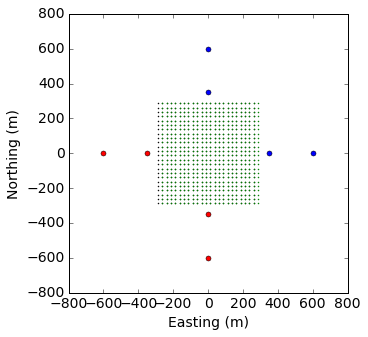

In [25]:
fig, ax = plt.subplots(1,1, figsize=(5,5))
ax.plot(Aloc1_x[0], Aloc1_x[1], 'ro', ms=5)
ax.plot(Bloc1_x[0], Bloc1_x[1], 'bo', ms=5)
ax.plot(Aloc2_x[0], Aloc2_x[1], 'ro', ms=5)
ax.plot(Bloc2_x[0], Bloc2_x[1], 'bo', ms=5)
ax.plot(Aloc1_y[0], Aloc1_y[1], 'ro', ms=5)
ax.plot(Bloc1_y[0], Bloc1_y[1], 'bo', ms=5)
ax.plot(Aloc2_y[0], Aloc2_y[1], 'ro', ms=5)
ax.plot(Bloc2_y[0], Bloc2_y[1], 'bo', ms=5)

ax.plot(Mx[:,0], Mx[:,1], 'k.', ms=2)
ax.plot(Nx[:,0], Nx[:,1], 'g.', ms=2)

# ax.plot(My[:,0], My[:,1], 'k.', ms=2)
# ax.plot(Ny[:,0], Ny[:,1], 'g.', ms=2)
# dat = mesh2D.plotImage(topoCC, ax=ax, pcolorOpts={'alpha':0.2})
# plt.colorbar(dat[0])
ax.set_xlim(-800, 800)
ax.set_ylim(-800, 800)
ax.set_xlabel("Easting (m)")
ax.set_ylabel("Northing (m)")    



In [26]:
rx_x = DC.Rx.Dipole(Mx_dr, Nx_dr)
rx_y = DC.Rx.Dipole(My_dr, Ny_dr)
# src0 = DC.Src.Dipole([rx_x, rx_y], Aloc0_x, Bloc0_x)
src1 = DC.Src.Dipole([rx_x, rx_y], Aloc1_x, Bloc1_x)
src2 = DC.Src.Dipole([rx_x, rx_y], Aloc2_x, Bloc2_x)
src3 = DC.Src.Dipole([rx_x, rx_y], Aloc1_y, Bloc1_y)
src4 = DC.Src.Dipole([rx_x, rx_y], Aloc2_y, Bloc2_y)

In [27]:
expmap = Maps.ExpMap(mesh)
actmap = Maps.InjectActiveCells(mesh, ~airind, np.log(1e-8))
mapping = expmap*actmap

In [28]:
m0 = np.ones_like(sigma)[~airind]*np.log(1e-4)

In [29]:
%%time
survey = DC.Survey([src1, src2, src3, src4])
problem = DC.Problem3D_CC(mesh, mapping=mapping)
problem.Solver = MumpsSolver
problem.pair(survey)
mtrue = np.log(sigma)[~airind]
f = problem.fields(mtrue)
dobs = survey.dpred(mtrue, f=f)

CPU times: user 10.2 s, sys: 837 ms, total: 11 s
Wall time: 7.27 s


In [30]:
dcdata = Survey.Data(survey, v=dobs)
Xx = 0.5*(Mx[:,0]+Nx[:,0]).reshape((23, 24), order="F")
Yx = Mx[:,1].reshape((23, 24), order="F")
Xy = My[:,0].reshape((24, 23), order="F")
Yy = 0.5*(My[:,1]+Ny[:,1]).reshape((24, 23), order="F")

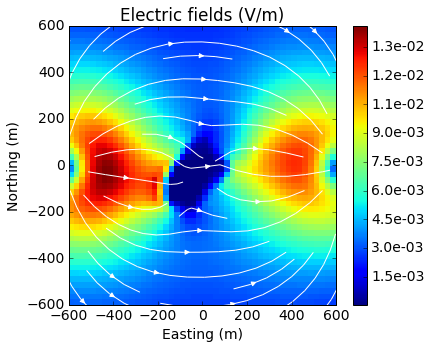

In [31]:
interact(lambda ind: vizEJ(sigma, ind, normal="Z", ftype="E"), ind=IntSlider(min=0, max=32,step=1, value=25))

<function __main__.<lambda>>

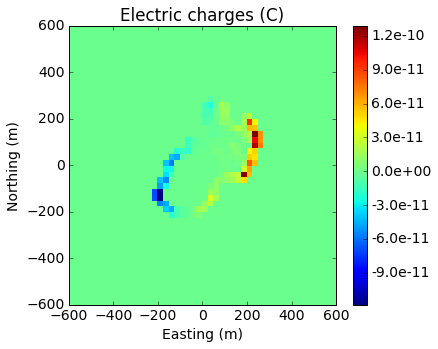

In [35]:
interact(lambda ind: vizEJ(sigma, ind, normal="Z", ftype="charg"), ind=IntSlider(min=0, max=32,step=1, value=25))

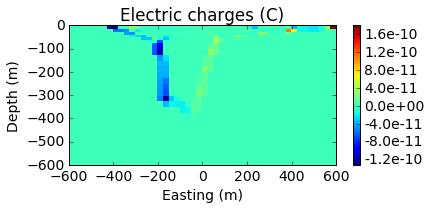

In [31]:
interact(lambda ind: vizEJ(sigma, ind, normal="Y", ftype="charg"), ind=IntSlider(min=0, max=32,step=1, value=25))

<function __main__.<lambda>>

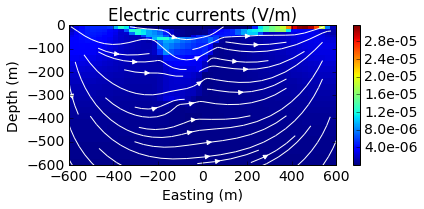

In [32]:
interact(lambda ind: vizEJ(sigma, ind, normal="Y", ftype="J"), ind=IntSlider(min=0, max=32,step=1, value=25))

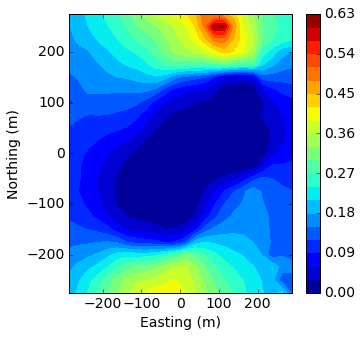

In [33]:
vizdata(dcdata, src3, rx_y, rxcomponent="Y")

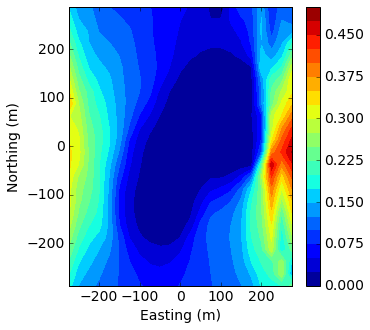

In [34]:
vizdata(dcdata, src1, rx_x, rxcomponent="X")

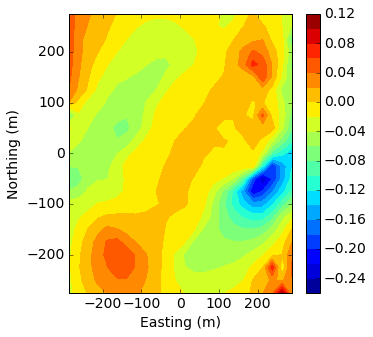

In [35]:
vizdata(dcdata, src1, rx_y, rxcomponent="Y")

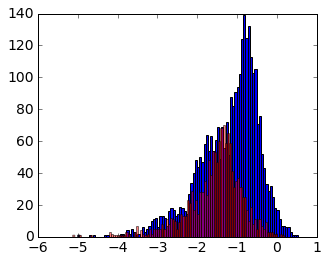

In [36]:
fig, ax = plt.subplots(1,1, figsize=(5,4))
a = ax.hist(np.log10(dobs[dobs>0.]), bins=100)
b = ax.hist(np.log10(-dobs[dobs<0.]), bins=100, color='r', alpha=0.5)

In [37]:
depth = 1./(abs(mesh.gridCC[:,2]))**1.5
depth = depth/depth.max()

(-600, 0.0)

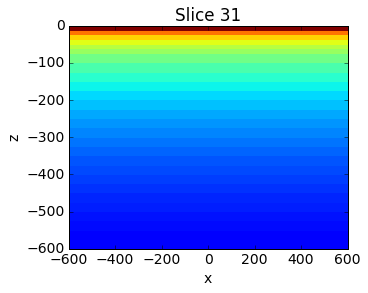

In [38]:
fig, ax = plt.subplots(1,1, figsize=(5,4))
mesh.plotSlice(np.log10(depth), normal="Y", streamOpts={'color':'w'}, ax=ax)
ax.set_xlim(-600, 600)
ax.set_ylim(-600, 0.)    

In [29]:
# from SimPEG import DataMisfit, Regularization, Optimization, Directives, InvProblem, Inversion
# regmap = Maps.IdentityMap(nP=m0.size)
# std = 0.05
# eps = 1e-3
# survey.std = std
# survey.eps = eps
# #TODO put warning when dobs is not set!
# survey.dobs = dobs
# dmisfit = DataMisfit.l2_DataMisfit(survey)
# reg = Regularization.Simple(mesh, mapping=regmap, indActive=~airind)
# reg.wght = depth[~airind]
# opt = Optimization.InexactGaussNewton(maxIter = 20)
# invProb = InvProblem.BaseInvProblem(dmisfit, reg, opt)
# # Create an inversion object
# beta = Directives.BetaSchedule(coolingFactor=5, coolingRate=2)
# betaest = Directives.BetaEstimate_ByEig(beta0_ratio=1e0)
# save = Directives.SaveOutputEveryIteration()
# target = Directives.TargetMisfit()
# inv = Inversion.BaseInversion(invProb, directiveList=[beta,betaest, save, target])
# reg.alpha_s = 1e-4
# reg.alpha_x = 1.
# reg.alpha_y = 1.
# reg.alpha_z = 1.
# problem.counter = opt.counter = Utils.Counter()
# opt.LSshorten = 0.5
# opt.remember('xc')
# mopt = inv.run(m0)
# sigopt = mapping*mopt
# np.save("sigest", sigopt)

In [39]:
sigopt = np.load("sigest.npy")
# sigopt = mapping*mopt

In [40]:
from SimPEG import Survey
# datapred = invProb.dpred
# obsdata = Survey.Data(survey, v=dobs)
# preddata = Survey.Data(survey, v=datapred)

In [41]:
# figsize(8,3)
# plt.plot(obsdata[src1, rx_y])
# plt.plot(preddata[src1, rx_y], '.')

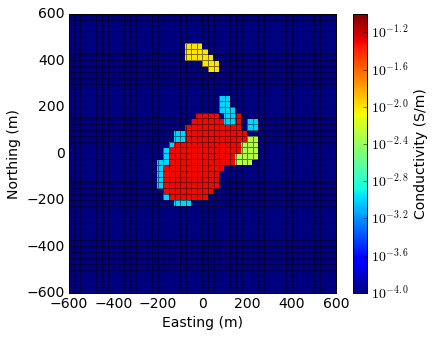

In [42]:
interact(lambda ind: viz(sigma, ind, normal="Z"), ind=IntSlider(min=0, max=32,step=1, value=30))

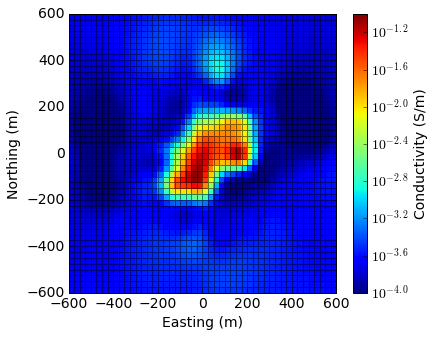

In [43]:
interact(lambda ind: viz(sigopt, ind, normal="Z"), ind=IntSlider(min=0, max=32,step=1, value=30))

<function __main__.<lambda>>

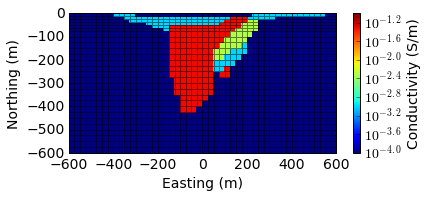

In [44]:
interact(lambda ind: viz(sigma, ind, normal="Y"), ind=IntSlider(min=0, max=32,step=1, value=30))

<function __main__.<lambda>>

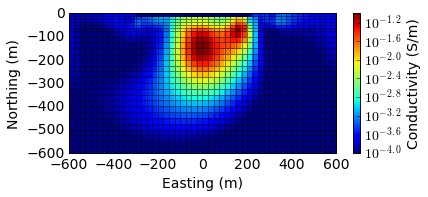

In [45]:
interact(lambda ind: viz(sigopt, ind, normal="Y"), ind=IntSlider(min=0, max=32,step=1, value=30))

In [37]:
import pickle
Results = {"mesh":mesh, "model_true":sigma, "model_pred":sigopt, "Obs":dobs}
outputs = open("DCresults", 'wb')
pickle.dump(Results, outputs)
outputs.close()